In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Class representing a 2D Ising model
class Ising:
    def __init__(self, N, J, H):
        self.lattice = np.random.choice([-1,1], size=(N,N)) # initial state
        self.N = N # dimension
        self.J = np.abs(J) # interaction energy, non-negative by definition
        self.H = H # external field

In [3]:
# Function to calculate energy change when spin(i,j) is flipped, assuming periodic boundary conditions
def energy_change_of_flip(state, pos_i, pos_j):
    return 2*state.lattice[pos_i,pos_j]*(state.J*(state.lattice[pos_i,(pos_j+1)%state.N] + state.lattice[(pos_i-1)%state.N,pos_j] + state.lattice[(pos_i+1)%state.N,pos_j] + state.lattice[pos_i,(pos_j-1)%state.N])+state.H)

In [4]:
# Monte Carlo sweep using Metropolis algorithm
def monte_carlo_sweep(state, temperature):
    for i in range(len(state.lattice)**2):
        # pick a spin randomly and calculate energy change if it's flipped
        pos_i = np.random.randint(0,len(state.lattice))
        pos_j = np.random.randint(0,len(state.lattice))
        delta_E = energy_change_of_flip(state,pos_i,pos_j)
        
        # to flip or not to flip?
        if delta_E < 0 or np.exp(-delta_E/temperature) > np.random.random():
            state.lattice[pos_i,pos_j] *= -1

In [5]:
# Function to calculate magnetisation
def calculate_magnetisation(state):
    return np.sum(state.lattice)

In [6]:
# Function to calculate energy
def calculate_energy(state):
    interaction_energy = 0.0
    for pos_i in range(len(state.lattice)):
        for pos_j in range(len(state.lattice)):
            interaction_energy += -state.J*state.lattice[pos_i,pos_j]*(state.lattice[pos_i,(pos_j+1)%state.N] + state.lattice[(pos_i-1)%state.N,pos_j] + state.lattice[(pos_i+1)%state.N,pos_j] + state.lattice[pos_i,(pos_j-1)%state.N])
    interaction_energy *= 0.5 # avoid double counting
    
    magnetisation_energy = -state.H*calculate_magnetisation(state)
    
    return interaction_energy+magnetisation_energy

In [7]:
# Metropolis algorithm
def Metropolis_algorithm(N_range, J, H, T_range, no_of_sweeps):
    # arrays to store magnetisation and energy time series
    M = np.zeros((len(N_range),len(T_range),no_of_sweeps))
    E = np.zeros((len(N_range),len(T_range),no_of_sweeps))
    M_normalized = np.zeros((len(N_range),len(T_range),no_of_sweeps))
    E_normalized = np.zeros((len(N_range),len(T_range),no_of_sweeps))
    
    # Monte Carlo sweeps
    for N_index in range(len(N_range)):
        for T_index in range(len(T_range)):
            state = Ising(N_range[N_index],J,H)
            for sweep in range(no_of_sweeps): # run!
                monte_carlo_sweep(state,T_range[T_index])
                
                M[N_index,T_index,sweep] = calculate_magnetisation(state)
                E[N_index,T_index,sweep] = calculate_energy(state)
                M_normalized[N_index,T_index,sweep] = M[N_index,T_index,sweep]/(state.N**2)
                E_normalized[N_index,T_index,sweep] = E[N_index,T_index,sweep]/(state.N**2)
                
                if sweep%100 == 0: # output checkpoints
                    print('N = {0}, T = {1}, sweep = {2}'.format(N_range[N_index],T_range[T_index],sweep))
    
    return M, E, M_normalized, E_normalized

In [8]:
# Plot evolution of data over time
def plot_time_series(data, N_range, T_range, yname):
    for N_index in range(len(N_range)):
        for T_index in range(len(T_range)):
            plt.plot(range(len(data[N_index,T_index,:])),data[N_index,T_index,:],label='N = {0}, T = {1}'.format(N_range[N_index],T_range[T_index]))
        plt.legend(loc='best')
        plt.xlabel('Sweeps')
        plt.ylabel(yname)
        plt.savefig('plots/{0} vs Sweeps {1}.png'.format(yname,N_range[N_index]))
        plt.figure()

In [11]:
# Investigate time evolution
# Set parameters
Ns = [4, 8, 12]
J = 1.0
H = 0.0
Ts = [0.5, 2.269, 4.0]
sweeps = 2000

# Run the experiment
magnetisation, energy, magnetisation_per_site, energy_per_site = Metropolis_algorithm(Ns,J,H,Ts,sweeps)

N = 4, T = 0.5, sweep = 0
N = 4, T = 0.5, sweep = 100
N = 4, T = 0.5, sweep = 200
N = 4, T = 0.5, sweep = 300
N = 4, T = 0.5, sweep = 400
N = 4, T = 0.5, sweep = 500
N = 4, T = 0.5, sweep = 600
N = 4, T = 0.5, sweep = 700
N = 4, T = 0.5, sweep = 800
N = 4, T = 0.5, sweep = 900
N = 4, T = 0.5, sweep = 1000
N = 4, T = 0.5, sweep = 1100
N = 4, T = 0.5, sweep = 1200
N = 4, T = 0.5, sweep = 1300
N = 4, T = 0.5, sweep = 1400
N = 4, T = 0.5, sweep = 1500
N = 4, T = 0.5, sweep = 1600
N = 4, T = 0.5, sweep = 1700
N = 4, T = 0.5, sweep = 1800
N = 4, T = 0.5, sweep = 1900
N = 4, T = 2.269, sweep = 0
N = 4, T = 2.269, sweep = 100
N = 4, T = 2.269, sweep = 200
N = 4, T = 2.269, sweep = 300
N = 4, T = 2.269, sweep = 400
N = 4, T = 2.269, sweep = 500
N = 4, T = 2.269, sweep = 600
N = 4, T = 2.269, sweep = 700
N = 4, T = 2.269, sweep = 800
N = 4, T = 2.269, sweep = 900
N = 4, T = 2.269, sweep = 1000
N = 4, T = 2.269, sweep = 1100
N = 4, T = 2.269, sweep = 1200
N = 4, T = 2.269, sweep = 1300
N = 4, T =

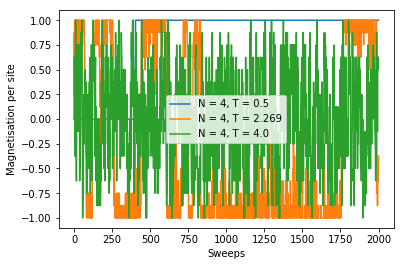

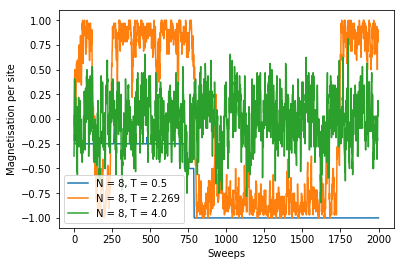

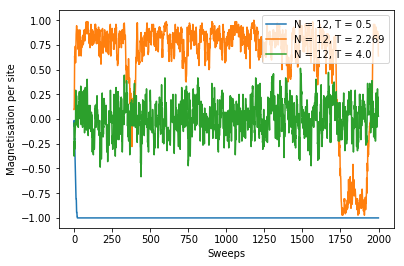

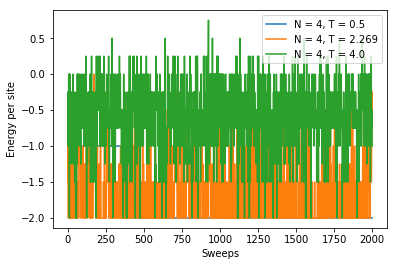

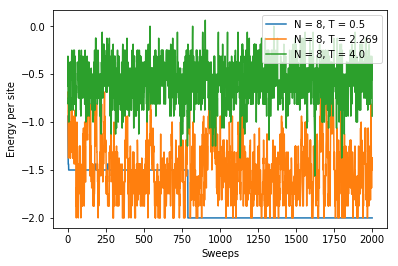

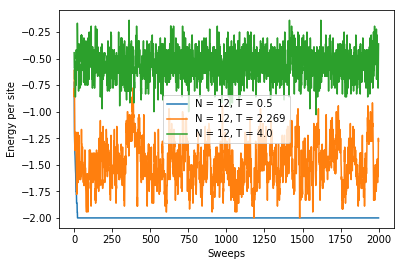

In [12]:
# Plot time evolution
plot_time_series(magnetisation_per_site,Ns,Ts,'Magnetisation per site')
plot_time_series(energy_per_site,Ns,Ts,'Energy per site')